In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pynwb import TimeSeries
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax

# Load Data

In [ ]:
path = "/stelmo/sam/c3po_datasets/sub-Han_desc-train_behavior+ecephys.nwb"
import os

os.path.exists(path)

io = NWBHDF5IO(path, "r")
nwbfile = io.read()

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.4.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


### Behavior dataframe

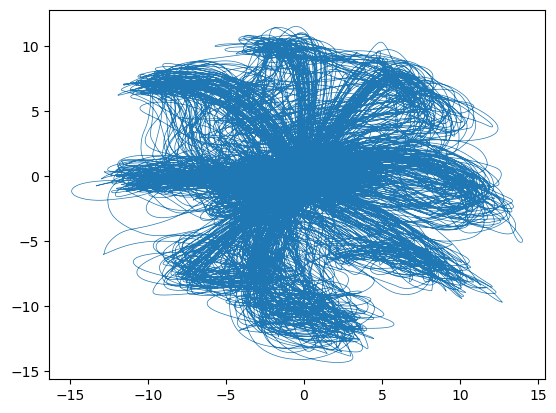

In [6]:
data = []
for object in nwbfile.objects.values():
    if isinstance(object, TimeSeries):
        if "hand" in object.name.lower() or "hand" in object.description.lower():
            data.append(object)
behavior_df = {}
for d in data:
    for i, dim in enumerate(["x", "y"]):
        behavior_df[f"{d.name}_{dim}"] = d.data[:, i]

behavior_df = pd.DataFrame(behavior_df, index=d.get_timestamps())
behavior_df


plt.plot(behavior_df["hand_pos_x"], behavior_df["hand_pos_y"], lw=0.5)
trials_df = nwbfile.trials.to_dataframe()

### Spike Data

In [7]:
# from jax.nn import one_hot

units_df = nwbfile.units.to_dataframe()

t_spike = []
id_spike = []
for i, spikes in enumerate(units_df["spike_times"]):
    t_spike.extend(spikes)
    id_spike.extend([i] * len(spikes))
ind = np.argsort(t_spike)
t_spike = np.array(t_spike)[ind]
id_spike = np.array(id_spike)[ind]

delta_t = np.diff(t_spike) * 1000  # convert to ms
waveforms = id_spike[1:].astype(np.int16)

ind_valid = np.where(delta_t > 0)[0]
delta_t = delta_t[ind_valid]
waveforms = waveforms[ind_valid]

delta_t.shape, waveforms.shape

np.mean(delta_t), np.std(delta_t), (t_spike.max() - t_spike.min()) / 60

(2.78305990204288, 2.57739697813634, 37.05741666666667)

In [60]:
from spyglass.common.common_interval import Interval

val = trials_df.copy()
val = val[val.ctr_hold_bump == False]
val = val[val.split != "none"]
val = val[val.split != "none"]
starts = val.move_onset_time.values
rng = (-0.1, 0.5)

valid_times = np.zeros(t_spike.shape[0], dtype=bool)
movement_start_intervals = []
for s in starts:
    if np.isnan(s):
        continue
    movement_start_intervals.append([s + rng[0], s + rng[1]])
    interval = Interval(np.array([[s + rng[0], s + rng[1]]]))
    reach_inds = interval.contains(t_spike, as_indices=True)
    # print(s, reach_inds.size)
    valid_times[reach_inds] = True
movement_start_intervals = Interval(np.array(movement_start_intervals))

In [ ]:
# seg_length = 5000
# n_overlap = 1000
# n_segments = (len(delta_t) - seg_length) // n_overlap + 1

# delta_t_train = np.zeros((n_segments, seg_length - 1), dtype=np.float32)
# waveforms_train = np.zeros((n_segments, seg_length - 1, 1), dtype=waveforms.dtype)
# for i in range(n_segments):
#     start = i * n_overlap
#     end = start + seg_length
#     delta_t_train[i] = delta_t[start : end - 1]
#     waveforms_train[i, :, 0] = waveforms[start : end - 1]
# # delta_t_train *= 1000  # convert to ms

seg_length = 500
n_overlap = 100
n_segments = (len(delta_t) - seg_length) // n_overlap + 1

# delta_t_train = np.zeros((n_segments, seg_length - 1), dtype=np.float32)
# waveforms_train = np.zeros(
#     (n_segments, seg_length - 1, len(units_df)), dtype=np.float32
# )
delta_t_train = []
waveforms_train = []
for i in range(n_segments):

    start = i * n_overlap
    end = start + seg_length
    if np.mean(valid_times[start:end]) < 0.5:
        continue
    delta_t_train.append(delta_t[start : end - 1])
    waveforms_train.append(waveforms[start : end - 1])
delta_t_train = np.array(delta_t_train, dtype=np.float32)
waveforms_train = np.array(waveforms_train, dtype=np.int16)[..., None]
print(delta_t_train.shape, waveforms_train.shape)
# delta_t_train *= 1000  # convert to ms

(545, 499) (545, 499, 1)


# Import C3PO and build model


In [ ]:
import os

os.chdir("..")
from src.c3po.model.model import C3PO

In [71]:
# prep data for model
from src.c3po.model.util import prep_training_data
from src.c3po.model.model import C3PO

keep_params = 0  # True

if keep_params:
    store_params = params.copy()


# hyperparams
latent_dim = 16  # 4
context_dim = 16  # 6


n_neg_samples = 2
encoder_args = dict(
    encoder_model="sorted_spikes",
    n_units=np.max(waveforms),
    gauss_noise_std=0,
    input_format="indices",
)


# dilations = [
#     1,
#     2,
#     4,
#     8,
# ]
# dilations = dilations * 2
# kernels = [
#     32,
#     32,
#     64,
#     64,
# ]
# kernels = kernels * 2
dilations = [
    1,
    2,
    4,
    8,
]
dilations = dilations * 2
kernels = [
    16,
    8,
    8,
    8,
]
kernels = kernels * 2

context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,  # [1, 2, 3, 5, 7, 9, 17, 21, 1, 2, 3, 5, 7, 9, 17, 21],
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=10,
    smoothing_decay=1,
    categorical=False,
)

# context_args = dict(
#     context_model="slidingWindow",
#     window_size=100,
# )

rate_args = dict(
    rate_model="bilinear",
)

distribution = "poisson"  # "multi_loglogistic"  # "gompertz"
predicted_sequence_length = 1


model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution,
    latent_dim,
    context_dim,
    n_neg_samples,
    predicted_sequence_length,
    return_embeddings_in_call=True,
)


rand_key = jax.random.PRNGKey(0)
params = model.init(
    jax.random.PRNGKey(1), waveforms_train[:2, :300], delta_t_train[:2, :300], rand_key
)
init_params = params.copy()
run_model = jax.jit(model.apply)
if keep_params:
    params = store_params.copy()

## Training

In [72]:
from src.c3po.model.model import loss


def change_n_neg_samples(params, x, delta_t, rand_key, n_neg_samples):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    run_model = jax.jit(model.apply)

    def training_loss_fun(params, x, delta_t, rand_key):
        pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
        return model.contrastive_loss(
            pos_params,
            neg_params,
            delta_t,
            z[:, predicted_sequence_length:],
            neg_z,
        )

    return jax.value_and_grad(training_loss_fun)


def training_loss_fun(params, x, delta_t, rand_key):
    model = C3PO(
        encoder_args,
        context_args,
        rate_args,
        distribution,
        latent_dim,
        context_dim,
        n_neg_samples,
        predicted_sequence_length,
        return_embeddings_in_call=True,
    )
    run_model = jax.jit(model.apply)

    pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
    return model.contrastive_loss(
        pos_params,
        neg_params,
        delta_t,
        z[:, predicted_sequence_length:],
        neg_z,
    )


loss_grad_fn = jax.value_and_grad(training_loss_fun)

In [73]:
from tqdm import tqdm
import optax

n_neg = 4
learning_rate = 3e-4
batch_size = 128
default_buffer = 10

optimizer = optax.chain(
    optax.adam(learning_rate),
)
# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)


loss_grad_fn = change_n_neg_samples(
    params, waveforms_train, delta_t_train, rand_key, n_neg
)
tracked_loss = []
buffer = default_buffer
for i in range(5000):
    ind = np.arange(waveforms_train.shape[0])
    np.random.shuffle(ind)
    epoch_loss = []
    j = 0
    with tqdm(
        total=waveforms_train.shape[0], desc=f"Epoch {i+1}/{3000}", unit="samples"
    ) as pbar:
        prev_params = params.copy()  # store params from end of previous epoch
        while j < waveforms_train.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            if len(batch_inds) < batch_size:
                break
            loss_val, grads = loss_grad_fn(
                params, waveforms_train[batch_inds], delta_t_train[batch_inds], rand_key
            )
            if not np.isfinite(loss_val):
                params = prev_params.copy()
                raise ValueError("Loss is not finite")
            # print(loss_val)
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            j += batch_size

            pbar.update(batch_size)
            pbar.set_postfix(
                loss=np.mean(epoch_loss), n_neg=n_neg, batch_size=batch_size
            )
            # break
    tracked_loss.append(np.mean(epoch_loss))
    buffer -= 1
    if (np.mean(tracked_loss[-5:-1]) < tracked_loss[-1] * 1.01) and buffer <= 0:
        if n_neg < 120:
            n_neg *= 2
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, waveforms_train, delta_t_train, rand_key, n_neg
            )
            buffer = default_buffer
        elif batch_size > 8:
            n_neg = 8
            batch_size = int(batch_size // 2)
            jax.clear_caches()
            del loss_grad_fn
            loss_grad_fn = change_n_neg_samples(
                params, waveforms_train, delta_t_train, rand_key, n_neg
            )
            buffer = default_buffer
        else:
            break

Epoch 1/3000:  94%|█████████▍| 512/545 [00:10<00:00, 48.13samples/s, batch_size=128, loss=1.61, n_neg=4]
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch 260/3000: 100%|█████████▉| 544/545 [00:14<00:00, 37.74samples/s, batch_size=8, loss=4.3, n_neg=128]


# Create Analysis object and store

In [75]:
from src.c3po.analysis.analysis import C3poAnalysis

analysis_encoder_args = {**encoder_args}
# analysis_encoder_args.update({"gauss_noise_std": 0})
model_args = dict(
    encoder_args=analysis_encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution=distribution,
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=predicted_sequence_length,
    sample_params=None,
)
analysis = C3poAnalysis(model=model, model_args=model_args, params=params)

In [77]:
# embed data and make pca
analysis.embed_data(
    waveforms[None, :, None],
    delta_t[None, :],
    delta_t_units="ms",
    first_mark_time=t_spike[0],
)
t_interp = np.arange(np.min(t_spike), np.max(t_spike), 0.001)
analysis.interpolate_context(t_interp)
analysis.fit_context_pca()

 94%|█████████▍| 750000/798921 [00:01<00:00, 441488.46it/s]


In [79]:
model_name = "monkey_s1_bump_reach_REACH_ONLY_16d"

from flax import serialization
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage()
insert_key = {
    "model_name": model_name,
    "encoder_args": encoder_args,
    "context_args": context_args,
    "rate_args": rate_args,
    "latent_dim": latent_dim,
    "context_dim": context_dim,
    "learned_params": serialization.to_bytes(params),
    "input_shape": np.array(waveforms_train.shape[-1]),
}

C3POStorage().insert1(insert_key)
analysis.save_embedding(f"/stelmo/sam/c3po_results/{model_name}_embedding.npz")

([<matplotlib.lines.Line2D at 0x7f53bc553700>,
  <matplotlib.lines.Line2D at 0x7f53bc550160>],)

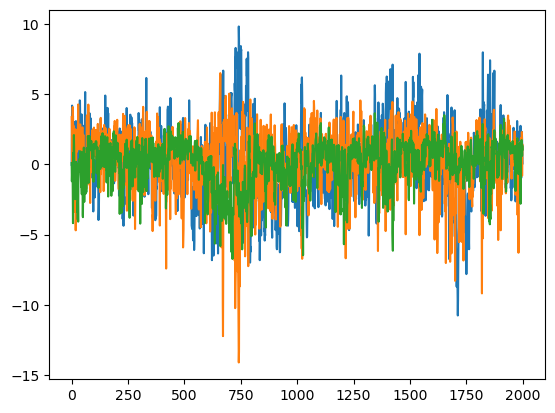

In [78]:
plt.plot(analysis.c_pca[25000:27000, :3]),